In [1]:
import pandas as pd
from sodapy import Socrata
#aqui sacamos las tablas de datos de hospitales y desfibriladores 
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get_all("wpud-ukyg")
hospitales = client.get_all("8gmd-gz7i")

df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 


url = "https://www.idescat.cat/serveis/consultes/ca/censph_10_mun_2024.csv"

df_cens = pd.read_csv(url, sep=";", encoding="utf-8")
df_cens.head()

df_desfibriladors

C:\Users\German\AppData\Local\Temp\ipykernel_23780\1191318993.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


,numero_inscripcio,fabricant,marca_model,numero_serie,vehicle,nom_centre,tipus_via,nom_via,numero_via,codi_postal,...,hora_fi_11,dia_13,hora_inici_13,hora_fi_13,hora_inici_12,hora_fi_12,dia_12,dia_14,hora_inici_14,hora_fi_14
0,12687,HeartSine Technologies Ltd,Samaritan PAD 300P,20E90005776,Sí,- 7222LNK,Plaça,de Catalunya,12,17480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2594,Altre fabricant,Altre Marca/Model Altre fabricant,4355424,No,AJUNTAMENT D'EL FAR D'EMPORDÀ,Passeig,PAU CASALS,SN,17469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8425,Altre fabricant,Altre Marca/Model Altre fabricant,16E00020755,No,AJUNTAMENT DE LA TORRE DE CAPDELLA,Plaça,DE L'AJUNTAMENT,1,25515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11072,Cardiac Science,Powerheart G5,D00000163591,No,Henkel,Carrer,Nord,5,08170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3430,Altre fabricant,Altre Marca/Model Altre fabricant,13D00805511,No,"NOA VISUAL GROUP, SL",Avinguda,Marti Alsina,2,17800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11475,14579,HeartSine Technologies Ltd,HeartSine Connected samaritan PAD 350P,23D90006017B23,No,Castellers de Lleida,Carrer,Nou,12,25002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11476,13767,HeartSine Technologies Ltd,HeartSine Connected samaritan PAD 350P,23D90019890B23,No,Residència Terraferma,Partida,Grao,0,25110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11477,15867,HeartSine Technologies Ltd,HeartSine Connected samaritan PAD 350P,22D91148217F22,No,Residència Sant Salvador de l'HortaResidència ...,Carrer,de les Argiles,44,17430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11478,9991,Altre fabricant,Altre Marca/Model Altre fabricant,18D00025550,No,EDIFICI AJUNTAMENT ELS ALAMÚS,Plaça,DE LA CREU,1,25221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df_clean=df_hospitales[df_hospitales["categoria"].str.contains("salut", na=False)]
df_clean = df_clean[["poblacio"]].copy()
df_clean["municipi"] = df_clean["poblacio"].str.upper().str.strip()
df_hospis = df_clean.groupby("municipi").size().reset_index(name="hosp_count")


In [3]:

# Filter rows where edat == "total"
df_cens_total = df_cens[(df_cens["edat"] == "total") & (df_cens["sexe"] == "total")].copy()
df_cens_total = df_cens_total[df_cens_total["valor"] <= 5000000]
df_cens_total = df_cens_total.reset_index(drop=True)
df_cens_total = df_cens_total.rename(columns={"valor": "pob"})

# Keep only municipality name and population
df_cens_pop = df_cens_total[["municipi", "pob"]].copy()

# Clean municipality names for merging
df_cens_pop["municipi"] = df_cens_pop["municipi"].str.upper().str.strip()
df_cens_pop

,municipi,pob
0,ABELLA DE LA CONCA,161
1,ABRERA,12981
2,ÀGER,608
3,AGRAMUNT,5592
4,AGUILAR DE SEGARRA,291
...,...,...
942,VINAIXA,449
943,VINEBRE,426
944,VINYOLS I ELS ARCS,2425
945,VIVER I SERRATEIX,173


In [4]:

df_desfibriladors["municipi"] = df_desfibriladors["municipi"].str.upper().str.strip()
df_d_counts = df_desfibriladors.groupby("municipi").size().reset_index(name="desf_count")

df_merged = df_d_counts.merge(
    df_cens_pop[["municipi", "pob"]],
    left_on="municipi",
    right_on="municipi",
    how="left"
)

df_merged["desf_per_1000"] = df_merged["desf_count"] / df_merged["pob"] * 1000


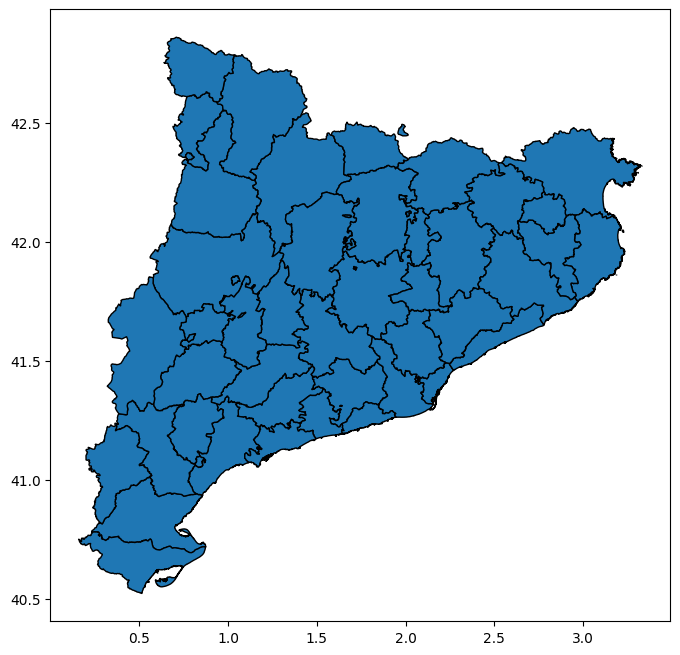

In [8]:
#ahora voy a limpiar los datos, empiezo con desfibriladores
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis = gpd.read_file(data_dir + "muni.json")
# Fix invalid geometries to prevent topology errors
municipis["geometry"] = municipis["geometry"].make_valid()
comarcas = gpd.read_file(data_dir + "comarcas.json")


comarcas.plot(figsize=(8, 8), edgecolor="black")
plt.show()


In [16]:
# Verificar columnas disponibles
print("Columnas en df_desfibriladors:", df_desfibriladors.columns.tolist())
print("\nColumnas en df_cens_total:", df_cens_total.columns.tolist())

Columnas en df_desfibriladors: ['numero_inscripcio', 'fabricant', 'marca_model', 'numero_serie', 'vehicle', 'nom_centre', 'tipus_via', 'nom_via', 'numero_via', 'codi_postal', 'municipi', 'codi_municipi', 'comarca', 'codi_comarca', 'provincia', 'codi_provincia', 'titular', 'espai_fisic', 'longitud', 'latitud', 'georeferencia', ':@computed_region_bh64_c7uy', 'pis', 'escala', 'dia_01', 'dia_03', 'dia_05', 'hora_inici_01', 'hora_fi_01', 'dia_02', 'hora_inici_02', 'hora_fi_02', 'hora_inici_03', 'hora_fi_03', 'hora_inici_04', 'hora_fi_04', 'hora_inici_05', 'hora_fi_05', 'hora_inici_06', 'hora_fi_06', 'hora_inici_07', 'hora_fi_07', 'hora_inici_08', 'hora_fi_08', 'hora_inici_09', 'hora_fi_09', 'hora_inici_10', 'hora_fi_10', 'dia_07', 'bloc', 'porta', 'dia_04', 'dia_06', 'dia_08', 'dia_09', 'dia_10', 'dia_11', 'hora_inici_11', 'hora_fi_11', 'dia_13', 'hora_inici_13', 'hora_fi_13', 'hora_inici_12', 'hora_fi_12', 'dia_12', 'dia_14', 'hora_inici_14', 'hora_fi_14']

Columnas en df_cens_total: ['any

In [48]:
# Agrupar desfibriladores por comarca
df_desfibriladors["comarca"] = df_desfibriladors["comarca"].str.upper().str.strip()
df_d_comarca = df_desfibriladors.groupby("comarca").size().reset_index(name="desf_count")

# Agregar comarca a los datos de población usando el merge con municipis
municipis["NOMMUNI"] = municipis["NOMMUNI"].str.upper().str.strip()
municipis["NOMCOMAR"] = municipis["NOMCOMAR"].str.upper().str.strip()

# Normalizar nombres de municipios en df_cens_total
df_cens_total_norm = df_cens_total.copy()
df_cens_total_norm["municipi"] = df_cens_total_norm["municipi"].str.upper().str.strip()

# Merge población con municipios para obtener comarca
df_cens_comarca = df_cens_total_norm.merge(
    municipis[["NOMMUNI", "NOMCOMAR"]],
    left_on="municipi",
    right_on="NOMMUNI",
    how="left"
)

# Agrupar población por comarca
df_pob_comarca = df_cens_comarca.groupby("NOMCOMAR")["pob"].sum().reset_index()
df_pob_comarca.columns = ["comarca", "pob"]

# Merge desfibriladores y población por comarca
df_merged_comarca = df_d_comarca.merge(
    df_pob_comarca[["comarca", "pob"]],
    left_on="comarca",
    right_on="comarca",
    how="left"
)

df_merged_comarca["desf_per_1000"] = df_merged_comarca["desf_count"] / df_merged_comarca["pob"] * 1000
df_merged_comarca

,comarca,desf_count,pob,desf_per_1000
0,ALT CAMP,64,41839.0,1.529673
1,ALT EMPORDÀ,284,131669.0,2.156924
2,ALT PENEDÈS,236,109563.0,2.154012
3,ALT URGELL,53,6936.0,7.641292
4,ALTA RIBAGORÇA,15,506.0,29.644269
5,ANOIA,442,114898.0,3.846890
6,ARAN,30,NaN,NaN
7,BAGES,258,181213.0,1.423739
8,BAIX CAMP,211,194680.0,1.083830
9,BAIX EBRE,134,63873.0,2.097913


In [49]:
# Merge con geometría de comarcas
comarcas["NOMCOMAR"] = comarcas["NOMCOMAR"].str.upper().str.strip()

des_comarca = comarcas.merge(
    df_merged_comarca[["comarca", "desf_per_1000", "desf_count", "pob"]],
    left_on="NOMCOMAR",
    right_on="comarca",
    how="left"
)

des_comarca["desf_per_1000"] = des_comarca["desf_per_1000"].fillna(0)
des_comarca["desf_count"] = des_comarca["desf_count"].fillna(0)
des_comarca

,CODICOMAR,NOMCOMAR,CAPCOMAR,AREAC5000,geometry,comarca,desf_per_1000,desf_count,pob
0,01,ALT CAMP,Valls,537.8597,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",ALT CAMP,1.529673,64.0,41839.0
1,02,ALT EMPORDÀ,Figueres,1356.9070,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",ALT EMPORDÀ,2.156924,284.0,131669.0
2,03,ALT PENEDÈS,Vilafranca del Penedès,592.5553,"MULTIPOLYGON (((1.63295 41.50751, 1.63009 41.5...",ALT PENEDÈS,2.154012,236.0,109563.0
3,04,ALT URGELL,la Seu d'Urgell,1446.6785,"MULTIPOLYGON (((1.31892 41.9822, 1.31969 41.98...",ALT URGELL,7.641292,53.0,6936.0
4,05,ALTA RIBAGORÇA,el Pont de Suert,427.2234,"MULTIPOLYGON (((0.88506 42.6271, 0.88494 42.62...",ALTA RIBAGORÇA,29.644269,15.0,506.0
5,06,ANOIA,Igualada,867.0471,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",ANOIA,3.846890,442.0,114898.0
6,07,BAGES,Manresa,1092.7982,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",BAGES,1.423739,258.0,181213.0
7,08,BAIX CAMP,Reus,696.4467,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",BAIX CAMP,1.083830,211.0,194680.0
8,09,BAIX EBRE,Tortosa,1001.9343,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",BAIX EBRE,2.097913,134.0,63873.0
9,10,BAIX EMPORDÀ,la Bisbal d'Empordà,701.1957,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",BAIX EMPORDÀ,1.772643,232.0,130878.0


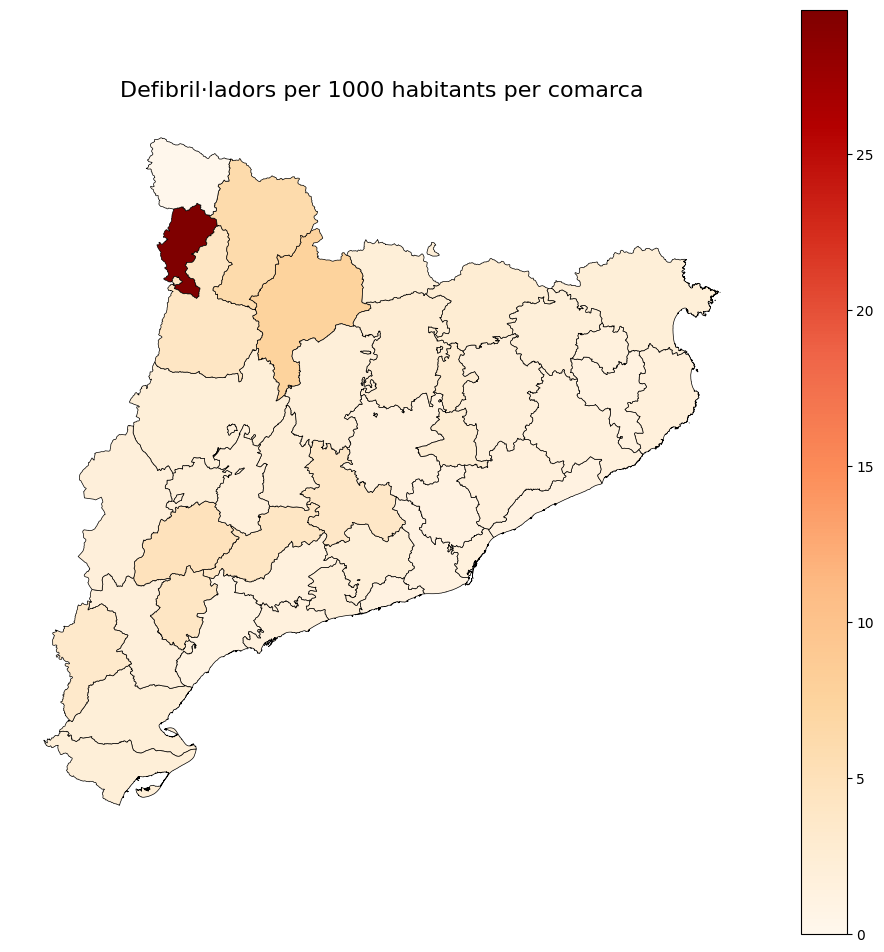

In [50]:
# Mapa de desfibriladores por comarca
fig, ax = plt.subplots(figsize=(12, 12))

des_comarca.plot(
    column="desf_per_1000",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.5
)

ax.set_title("Defibril·ladors per 1000 habitants per comarca", fontsize=16)
ax.axis("off")
plt.show()

In [51]:
# Agrupar hospitales por comarca
# Primero necesitamos obtener la comarca de cada hospital
df_hospis_comarca = df_clean.merge(
    municipis[["NOMMUNI", "NOMCOMAR"]],
    left_on="municipi",
    right_on="NOMMUNI",
    how="left"
)

# Agrupar por comarca
df_hospis_comarca_count = df_hospis_comarca.groupby("NOMCOMAR").size().reset_index(name="hosp_count")
df_hospis_comarca_count.columns = ["comarca", "hosp_count"]
df_hospis_comarca_count

,comarca,hosp_count
0,ALT EMPORDÀ,1
1,ALT PENEDÈS,4
2,ALT URGELL,4
3,ANOIA,1
4,BAGES,2
5,BAIX CAMP,3
6,BAIX EBRE,3
7,BAIX LLOBREGAT,16
8,BAIX PENEDÈS,1
9,BARCELONÈS,51


In [52]:
# Crear des_comarca_hospi (análogo a des_muni_hospi)
des_comarca_hospi = des_comarca.merge(
    df_hospis_comarca_count[["comarca", "hosp_count"]],
    left_on="NOMCOMAR",
    right_on="comarca",
    how="left"
)

des_comarca_hospi["hosp_count"] = des_comarca_hospi["hosp_count"].fillna(0)
des_comarca_hospi["desf_hosp"] = (des_comarca_hospi["hosp_count"] + des_comarca_hospi["desf_count"])/des_comarca_hospi["pob"]*1000
des_comarca_hospi["desf_hosp"] = des_comarca_hospi["desf_hosp"].fillna(0)
des_comarca_hospi

,CODICOMAR,NOMCOMAR,CAPCOMAR,AREAC5000,geometry,comarca_x,desf_per_1000,desf_count,pob,comarca_y,hosp_count,desf_hosp
0,01,ALT CAMP,Valls,537.8597,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",ALT CAMP,1.529673,64.0,41839.0,NaN,0.0,1.529673
1,02,ALT EMPORDÀ,Figueres,1356.9070,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",ALT EMPORDÀ,2.156924,284.0,131669.0,ALT EMPORDÀ,1.0,2.164519
2,03,ALT PENEDÈS,Vilafranca del Penedès,592.5553,"MULTIPOLYGON (((1.63295 41.50751, 1.63009 41.5...",ALT PENEDÈS,2.154012,236.0,109563.0,ALT PENEDÈS,4.0,2.190521
3,04,ALT URGELL,la Seu d'Urgell,1446.6785,"MULTIPOLYGON (((1.31892 41.9822, 1.31969 41.98...",ALT URGELL,7.641292,53.0,6936.0,ALT URGELL,4.0,8.217993
4,05,ALTA RIBAGORÇA,el Pont de Suert,427.2234,"MULTIPOLYGON (((0.88506 42.6271, 0.88494 42.62...",ALTA RIBAGORÇA,29.644269,15.0,506.0,NaN,0.0,29.644269
5,06,ANOIA,Igualada,867.0471,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",ANOIA,3.846890,442.0,114898.0,ANOIA,1.0,3.855594
6,07,BAGES,Manresa,1092.7982,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",BAGES,1.423739,258.0,181213.0,BAGES,2.0,1.434776
7,08,BAIX CAMP,Reus,696.4467,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",BAIX CAMP,1.083830,211.0,194680.0,BAIX CAMP,3.0,1.099240
8,09,BAIX EBRE,Tortosa,1001.9343,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",BAIX EBRE,2.097913,134.0,63873.0,BAIX EBRE,3.0,2.144881
9,10,BAIX EMPORDÀ,la Bisbal d'Empordà,701.1957,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",BAIX EMPORDÀ,1.772643,232.0,130878.0,NaN,0.0,1.772643


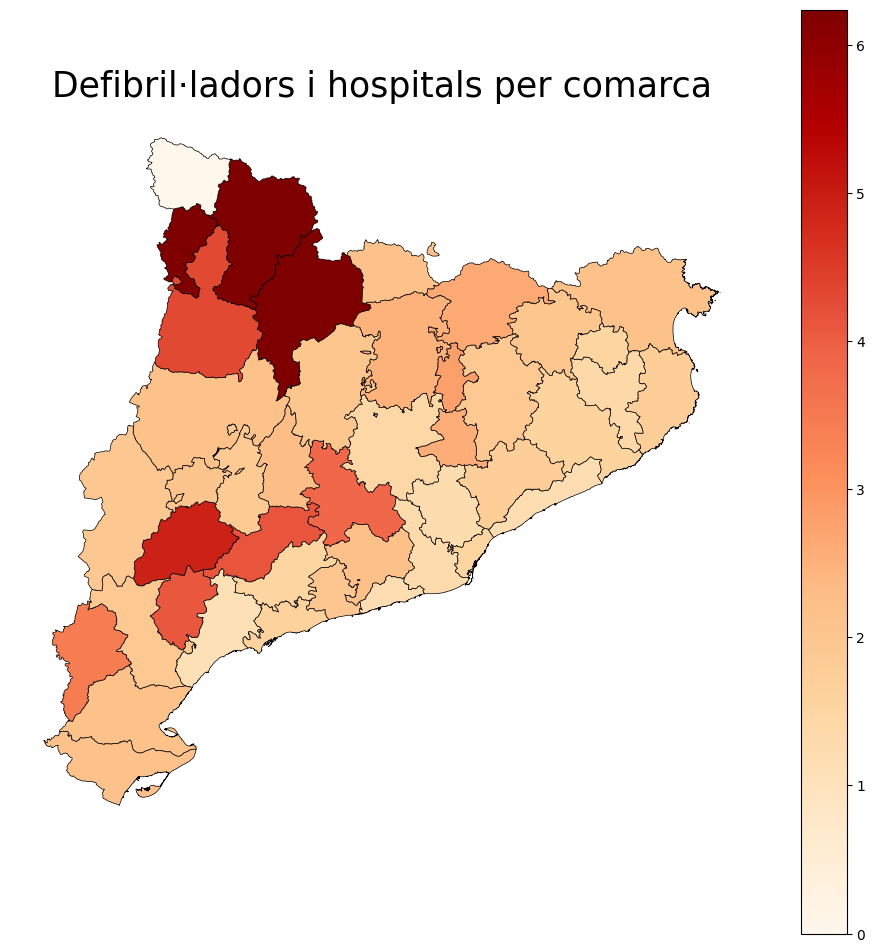

In [ ]:
# Mapa con hospitales y desfibriladores por comarca (capando outliers)
fig, ax = plt.subplots(figsize=(12, 12))

# Compute the 95th percentile
threshold = des_comarca_hospi["desf_hosp"].quantile(0.95)

# Crear una copia y capar los valores al percentil 95
des_comarca_capped = des_comarca_hospi.copy()
des_comarca_capped["desf_hosp_capped"] = des_comarca_capped["desf_hosp"].clip(upper=threshold)

des_comarca_capped.plot(
    column="desf_hosp_capped",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.5
)

ax.set_title("Defibril·ladors i hospitals per comarca", fontsize=25)
ax.axis("off")
plt.show()
#Vall d'Haran rarete


In [42]:
# Diagnosticar el problema
print("Estadísticas de desf_hosp:")
print(des_comarca_hospi["desf_hosp"].describe())
print("\nValores únicos de desf_hosp:")
print(des_comarca_hospi["desf_hosp"].value_counts())
print("\nComarcas con desf_hosp > 0:")
print(des_comarca_hospi[des_comarca_hospi["desf_hosp"] > 0][["NOMCOMAR", "desf_hosp", "desf_count", "hosp_count", "pob"]])

Estadísticas de desf_hosp:
count    43.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: desf_hosp, dtype: float64

Valores únicos de desf_hosp:
desf_hosp
0.0    43
Name: count, dtype: int64

Comarcas con desf_hosp > 0:
Empty DataFrame
Columns: [NOMCOMAR, desf_hosp, desf_count, hosp_count, pob]
Index: []


In [44]:
# Verificar los dataframes intermedios
print("df_hospis_comarca_count:")
print(df_hospis_comarca_count.head())
print("\ndes_comarca NOMCOMAR (primeros 5):")
print(des_comarca["NOMCOMAR"].head())
print("\ndes_comarca columnas:")
print(des_comarca.columns.tolist())
print("\ndes_comarca info sobre desf_count y pob:")
print(des_comarca[["NOMCOMAR", "desf_count", "pob"]].head(10))

df_hospis_comarca_count:
       comarca  hosp_count
0  ALT EMPORDÀ           1
1  ALT PENEDÈS           4
2   ALT URGELL           4
3        ANOIA           1
4        BAGES           2

des_comarca NOMCOMAR (primeros 5):
0          ALT CAMP
1       ALT EMPORDÀ
2       ALT PENEDÈS
3        ALT URGELL
4    ALTA RIBAGORÇA
Name: NOMCOMAR, dtype: object

des_comarca columnas:
['CODICOMAR', 'NOMCOMAR', 'CAPCOMAR', 'AREAC5000', 'geometry', 'comarca', 'desf_per_1000', 'desf_count', 'pob']

des_comarca info sobre desf_count y pob:
         NOMCOMAR  desf_count  pob
0        ALT CAMP        64.0  NaN
1     ALT EMPORDÀ       284.0  NaN
2     ALT PENEDÈS       236.0  NaN
3      ALT URGELL        53.0  NaN
4  ALTA RIBAGORÇA        15.0  NaN
5           ANOIA       442.0  NaN
6           BAGES       258.0  NaN
7       BAIX CAMP       211.0  NaN
8       BAIX EBRE       134.0  NaN
9    BAIX EMPORDÀ       232.0  NaN


In [45]:
# Verificar df_merged_comarca
print("df_merged_comarca:")
print(df_merged_comarca.head(10))
print("\nColumnas en df_merged_comarca:", df_merged_comarca.columns.tolist())

df_merged_comarca:
          comarca  desf_count  pob  desf_per_1000
0        ALT CAMP          64  NaN            NaN
1     ALT EMPORDÀ         284  NaN            NaN
2     ALT PENEDÈS         236  NaN            NaN
3      ALT URGELL          53  NaN            NaN
4  ALTA RIBAGORÇA          15  NaN            NaN
5           ANOIA         442  NaN            NaN
6            ARAN          30  NaN            NaN
7           BAGES         258  NaN            NaN
8       BAIX CAMP         211  NaN            NaN
9       BAIX EBRE         134  NaN            NaN

Columnas en df_merged_comarca: ['comarca', 'desf_count', 'pob', 'desf_per_1000']


In [46]:
# Verificar df_pob_comarca
print("df_pob_comarca:")
print(df_pob_comarca.head(10))
print("\ndf_d_comarca:")
print(df_d_comarca.head(10))

df_pob_comarca:
Empty DataFrame
Columns: [comarca, pob]
Index: []

df_d_comarca:
          comarca  desf_count
0        ALT CAMP          64
1     ALT EMPORDÀ         284
2     ALT PENEDÈS         236
3      ALT URGELL          53
4  ALTA RIBAGORÇA          15
5           ANOIA         442
6            ARAN          30
7           BAGES         258
8       BAIX CAMP         211
9       BAIX EBRE         134


In [47]:
# Verificar el merge
print("Primeros municipios en df_cens_total:")
print(df_cens_total["municipi"].head(10).tolist())
print("\nPrimeros municipios en municipis:")
print(municipis["NOMMUNI"].head(10).tolist())
print("\ndf_cens_comarca:")
print(df_cens_comarca.head(10))

Primeros municipios en df_cens_total:
['Abella de la Conca', 'Abrera', 'Àger', 'Agramunt', 'Aguilar de Segarra', 'Agullana', 'Aiguafreda', 'Aiguamúrcia', 'Aiguaviva', 'Aitona']

Primeros municipios en municipis:
['ABRERA', 'AGUILAR DE SEGARRA', 'ALELLA', 'ALPENS', "L'AMETLLA DEL VALLÈS", 'ARENYS DE MAR', 'ARENYS DE MUNT', 'ARGENÇOLA', 'ARGENTONA', 'ARTÉS']

df_cens_comarca:
    any     geo            municipi   edat   sexe  concepte  estat    pob  \
0  2024  250019  Abella de la Conca  total  total  població    NaN    161   
1  2024   80018              Abrera  total  total  població    NaN  12981   
2  2024  250024                Àger  total  total  població    NaN    608   
3  2024  250030            Agramunt  total  total  població    NaN   5592   
4  2024   80023  Aguilar de Segarra  total  total  població    NaN    291   
5  2024  170010            Agullana  total  total  població    NaN    910   
6  2024   80142          Aiguafreda  total  total  població    NaN   2582   
7  2024

In [38]:
#ahora por comarcas
comarcas["NOMCOMAR"] = comarcas["NOMCOMAR"].str.upper().str.strip()

des_comarca = comarcas.merge(
    df_merged[["municomarcacipi", "desf_per_1000", "desf_count", "pob"]],
    left_on="NOMCOMAR",
    right_on="comarca",
    how="left"
)

des_comarca["desf_per_1000"] = des_comarca["desf_per_1000"].fillna(0)
des_comarca["desf_count"] = des_comarca["desf_count"].fillna(0)

KeyError: "['municomarcacipi'] not in index"

In [11]:
municipis["NOMMUNI"] = municipis["NOMMUNI"].str.upper().str.strip()

des_muni = municipis.merge(
    df_merged[["municipi", "desf_per_1000", "desf_count", "pob"]],
    left_on="NOMMUNI",
    right_on="municipi",
    how="left"
)

des_muni["desf_per_1000"] = des_muni["desf_per_1000"].fillna(0)
des_muni["desf_count"] = des_muni["desf_count"].fillna(0)


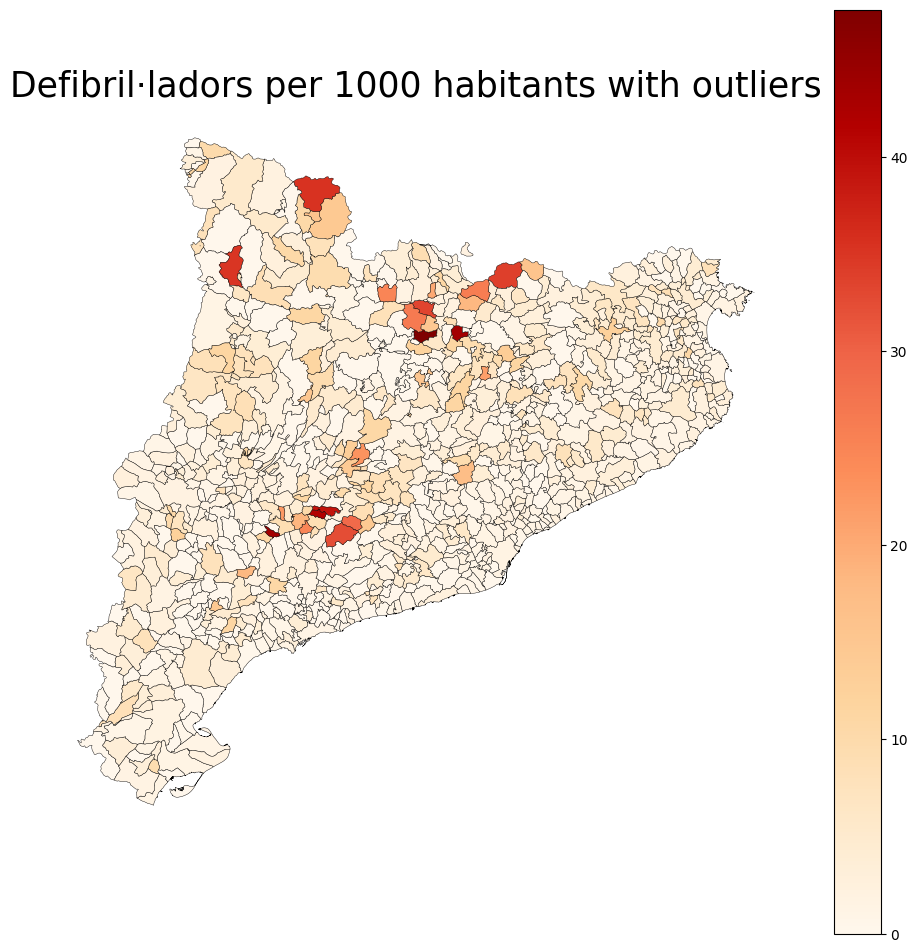

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))

des_muni.plot(
    column="desf_per_1000",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Defibril·ladors per 1000 habitants with outliers", fontsize=25)
ax.axis("off")
plt.show()

In [32]:
des_muni_hospi = des_muni.merge(
    df_hospis[["municipi", "hosp_count"]],
    left_on="NOMMUNI",
    right_on="municipi",
    how="left"
)

des_muni_hospi["hosp_count"] = des_muni_hospi["hosp_count"].fillna(0)
des_muni_hospi["desf_hosp"] = (des_muni_hospi["hosp_count"] + des_muni_hospi["desf_count"])/des_muni_hospi["pob"]*1000
des_muni_hospi["desf_hosp"] = des_muni_hospi["desf_hosp"].fillna(0)
des_muni_hospi

,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,...,NOMPROV,CAPPROV,geometry,municipi_x,desf_per_1000,desf_count,pob,municipi_y,hosp_count,desf_hosp
0,080018,ABRERA,Abrera,19.9781,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,...,Barcelona,Barcelona,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5...",ABRERA,3.312534,43.0,12981.0,NaN,0.0,3.312534
1,080023,AGUILAR DE SEGARRA,Aguilar de Segarra,43.2198,07,Bages,Manresa,07,Catalunya Central,*,...,Barcelona,Barcelona,"MULTIPOLYGON (((1.61829 41.76885, 1.61278 41.7...",NaN,0.000000,0.0,NaN,NaN,0.0,0.000000
2,080039,ALELLA,Alella,9.6346,21,Maresme,Mataró,01,Barcelona,Barcelona,...,Barcelona,Barcelona,"MULTIPOLYGON (((2.28512 41.51534, 2.28501 41.5...",ALELLA,1.274510,13.0,10200.0,NaN,0.0,1.274510
3,080044,ALPENS,Alpens,13.7788,43,Lluçanès,Prats de Lluçanès,07,Catalunya Central,*,...,Barcelona,Barcelona,"MULTIPOLYGON (((2.09411 42.14192, 2.09031 42.1...",ALPENS,3.703704,1.0,270.0,NaN,0.0,3.703704
4,080057,L'AMETLLA DEL VALLÈS,l'Ametlla del Vallès,14.0885,41,Vallès Oriental,Granollers,01,Barcelona,Barcelona,...,Barcelona,Barcelona,"MULTIPOLYGON (((2.24126 41.70273, 2.24178 41.7...",NaN,0.000000,0.0,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,439039,CAMARLES,Camarles,30.0157,09,Baix Ebre,Tortosa,05,Terres de l'Ebre,Tortosa,...,Tarragona,Tarragona,"MULTIPOLYGON (((0.64239 40.82154, 0.64239 40.8...",CAMARLES,0.583431,2.0,3428.0,NaN,0.0,0.583431
943,439044,L'ALDEA,l'Aldea,30.4743,09,Baix Ebre,Tortosa,05,Terres de l'Ebre,Tortosa,...,Tarragona,Tarragona,"MULTIPOLYGON (((0.60964 40.80699, 0.60855 40.8...",NaN,0.000000,0.0,NaN,NaN,0.0,0.000000
944,439057,SALOU,Salou,15.1248,36,Tarragonès,Tarragona,04,Camp de Tarragona,Tarragona,...,Tarragona,Tarragona,"MULTIPOLYGON (((1.13671 41.09788, 1.13391 41.1...",SALOU,1.412522,43.0,30442.0,NaN,0.0,1.412522
945,439060,L'AMPOLLA,l'Ampolla,35.6196,09,Baix Ebre,Tortosa,05,Terres de l'Ebre,Tortosa,...,Tarragona,Tarragona,"MULTIPOLYGON (((0.69184 40.85044, 0.69102 40.8...",NaN,0.000000,0.0,NaN,NaN,0.0,0.000000


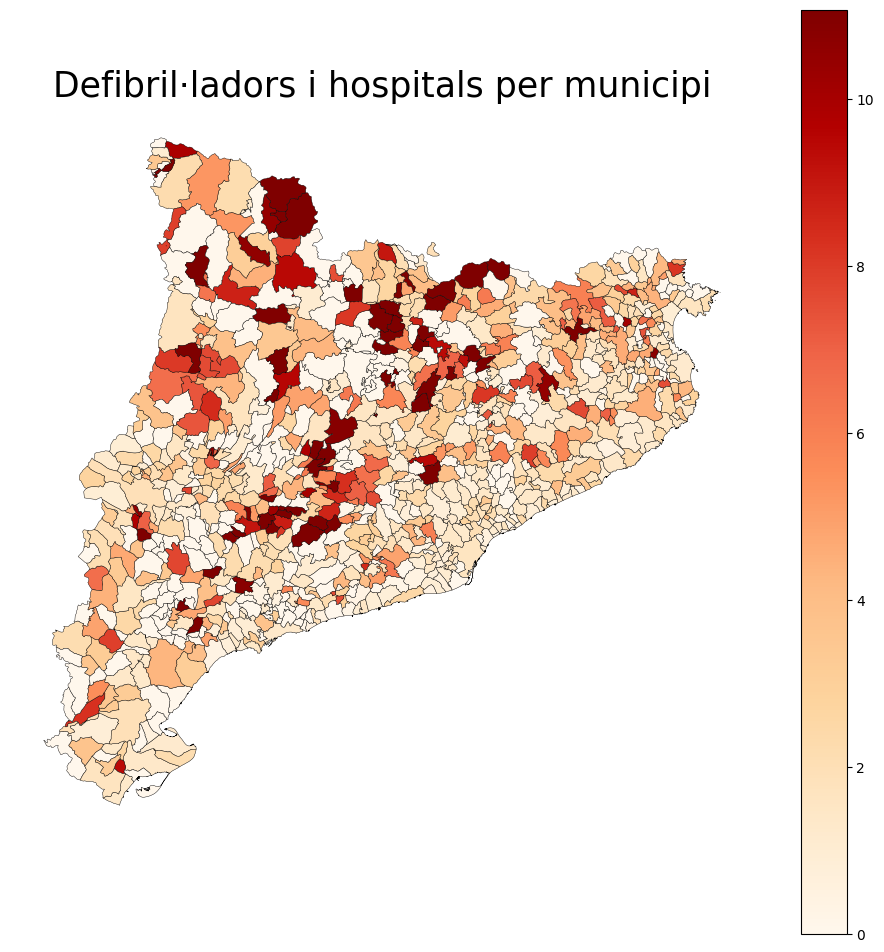

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))

# Compute the 95th percentile
threshold = des_muni_hospi["desf_hosp"].quantile(0.95)

# Crear una copia y capar los valores al percentil 95
des_muni_capped = des_muni_hospi.copy()
des_muni_capped["desf_hosp_capped"] = des_muni_capped["desf_hosp"].clip(upper=threshold)

des_muni_capped.plot(
    column="desf_hosp_capped",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Defibril·ladors i hospitals per municipi", fontsize=25)
ax.axis("off")
plt.show()

In [29]:
des_molt = des_muni_hospi[des_muni_hospi["desf_hosp"] > 15]


In [31]:
df_desfibriladors["titular"]


0                                      AJUNTAMENT DE ROSES
1                            AJUNTAMENT D'EL FAR D'EMPORDÀ
2                       AJUNTAMENT DE LA TORRE DE CAPDELLA
3                                     HENKEL IBÉRICA, S.A.
4                                     NOA VISUAL GROUP, SL
                               ...                        
11475                                 AJUNTAMENT DE LLEIDA
11476    SAR Residencial y Asistencial Sociosanitaria S...
11477          Serveis Públics d'Acció Social de Catalunya
11478                               AJUNTAMENT DELS ALAMÚS
11479                        AJUNTAMENT DE LA SEU D'URGELL
Name: titular, Length: 11480, dtype: object